We'll use a common dataset containing information about mall customers, including their annual income and spending score. Our goal, as an unsupervised task, is to identify distinct groups (segments) of customers based on these two features, without any prior labels telling us what these groups should be. Businesses use this kind of segmentation to understand their customer base better and tailor marketing strategies.

---

## Jupyter Notebook: K-Means Clustering - Real-World Example: Customer Segmentation

**Goal:** To segment mall customers into distinct groups based on their annual income and spending habits using the K-Means clustering algorithm. This helps in understanding different customer profiles for targeted marketing.

**Unsupervised Learning & K-Means:** We're applying unsupervised learning because we don't have predefined labels for customer segments. K-Means will help us discover these segments by grouping customers with similar income/spending patterns together, based on minimizing the distance between customers and the center (centroid) of their assigned segment.

---

### 1. Import Libraries

In [20]:
# Core libraries
import numpy as np
import pandas as pd

# For K-Means clustering algorithm
from sklearn.cluster import KMeans
# For scaling features (important for distance-based algorithms like K-Means)
from sklearn.preprocessing import StandardScaler

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: For automatically finding the elbow point
try:
    from kneed import KneeLocator
    kneed_available = True
except ImportError:
    kneed_available = False
    print("Optional: 'kneed' library not found. Install with 'pip install kneed' for automatic elbow detection.")

# Set plot style
sns.set(style="whitegrid")
# Set current time
import datetime
now = datetime.datetime.now()
print(f"Libraries imported successfully. Current time: {now.strftime('%Y-%m-%d %H:%M:%S')}")

Libraries imported successfully. Current time: 2025-04-20 12:25:37


---

### 2. Load Data

We'll load the "Mall Customer Segmentation" dataset directly from a URL. This dataset typically contains CustomerID, Gender, Age, Annual Income (in k$), and Spending Score (1-100).

In [21]:
# URL for the dataset (commonly used source)
dataset_url = "https://raw.githubusercontent.com/SteffiPeTaffy/machineLearningAZ/master/Machine%20Learning%20A-Z%20Template%20Folder/Part%204%20-%20Clustering/Section%2025%20-%20Hierarchical%20Clustering/Mall_Customers.csv"
# dataset_url = "https://raw.githubusercontent.com/uiuc-cse/data-fa14/gh-pages/data/mall.csv" # Alternative, possibly more stable URL

print(f"Loading dataset from: {dataset_url}")
try:
    customer_df = pd.read_csv(dataset_url)
    print("Dataset loaded successfully.")
except Exception as e:
    print(f"Error loading dataset: {e}")
    print("Please check the URL or your internet connection.")
    customer_df = pd.DataFrame() # Create empty DataFrame on error

if not customer_df.empty:
    # Display first few rows
    print("\nFirst 5 rows of the Mall Customer dataset:")
    print(customer_df.head())

    # Display basic info
    print("\nDataset Info:")
    customer_df.info()

    # Display summary statistics
    print("\nSummary Statistics:")
    with pd.option_context('display.float_format', '{:,.2f}'.format):
        print(customer_df.describe())

    # Check for missing values
    print("\nMissing values per column:")
    print(customer_df.isnull().sum())

Loading dataset from: https://raw.githubusercontent.com/SteffiPeTaffy/machineLearningAZ/master/Machine%20Learning%20A-Z%20Template%20Folder/Part%204%20-%20Clustering/Section%2025%20-%20Hierarchical%20Clustering/Mall_Customers.csv
Dataset loaded successfully.

First 5 rows of the Mall Customer dataset:
   CustomerID   Genre  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int

*Observation:* The dataset contains 200 customer entries with no missing values. We have features like Age, Annual Income, and Spending Score.

---

### 3. Prepare Data for Clustering

For this segmentation task, we'll focus on 'Annual Income' and 'Spending Score' as they often reveal interesting customer behaviors. We'll select these columns and then scale them. Scaling is important because K-Means relies on distance, and features with larger values (like income) could disproportionately influence the clustering if not scaled.

In [22]:
if not customer_df.empty:
    # Select relevant features for clustering
    # Renaming columns for easier access
    customer_df.rename(columns={'Annual Income (k$)': 'Annual_Income_k',
                                'Spending Score (1-100)': 'Spending_Score'}, inplace=True)

    # Create the feature matrix X using only the selected features
    X = customer_df[['Annual_Income_k', 'Spending_Score']].copy() # Use .copy() to avoid SettingWithCopyWarning

    print("\nSelected features for clustering (first 5 rows):")
    print(X.head())

    # --- Feature Scaling ---
    # Scale the features to have zero mean and unit variance
    print("\nScaling features...")
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # X_scaled is now a NumPy array
    print(f"Shape of scaled data: {X_scaled.shape}")
    print("First 5 rows of scaled data:")
    print(X_scaled[:5])
else:
    print("\nSkipping data preparation as dataset loading failed.")
    X = pd.DataFrame()
    X_scaled = np.array([])


Selected features for clustering (first 5 rows):
   Annual_Income_k  Spending_Score
0               15              39
1               15              81
2               16               6
3               16              77
4               17              40

Scaling features...
Shape of scaled data: (200, 2)
First 5 rows of scaled data:
[[-1.73899919 -0.43480148]
 [-1.73899919  1.19570407]
 [-1.70082976 -1.71591298]
 [-1.70082976  1.04041783]
 [-1.66266033 -0.39597992]]


---

### 4. Determine Optimal K (Elbow Method)

We apply the Elbow Method to our *scaled* data to find a suitable number of customer segments (K).


Calculating WCSS for Elbow Method...
Optimal K identified by KneeLocator: 5


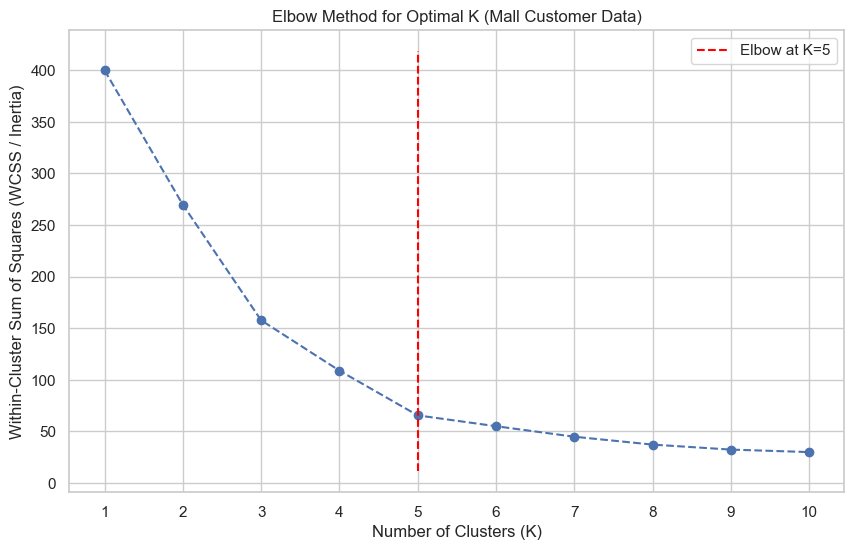

In [23]:
if X_scaled.size > 0:
    # Calculate WCSS (Inertia) for a range of K values using the SCALED data
    wcss = []
    k_range = range(1, 11) # Test K from 1 to 10

    print("\nCalculating WCSS for Elbow Method...")
    for k in k_range:
        kmeans_temp = KMeans(n_clusters=k,
                           init='k-means++',
                           n_init=10,
                           max_iter=300,
                           random_state=42)
        kmeans_temp.fit(X_scaled) # Fit on scaled data
        wcss.append(kmeans_temp.inertia_)

    # Plot the Elbow Method graph
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, wcss, marker='o', linestyle='--')
    plt.title('Elbow Method for Optimal K (Mall Customer Data)')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Within-Cluster Sum of Squares (WCSS / Inertia)')
    plt.xticks(k_range)
    plt.grid(True)

    # Optional: Use kneed library to find the elbow point automatically
    optimal_k = None
    if kneed_available:
        try:
            kn = KneeLocator(k_range, wcss, curve='convex', direction='decreasing')
            optimal_k = kn.elbow
            if optimal_k:
                plt.vlines(optimal_k, plt.ylim()[0], plt.ylim()[1], linestyles='dashed', color='red', label=f'Elbow at K={optimal_k}')
                plt.legend()
                print(f"Optimal K identified by KneeLocator: {optimal_k}")
            else:
                 print("KneeLocator could not find a distinct elbow point.")
        except Exception as e:
             print(f"Error using KneeLocator: {e}. Please identify elbow manually.")
    else:
        print("Identify the elbow point visually from the plot (often around K=5 for this dataset).")

    plt.show()

    # Manually set optimal K if needed (K=5 is commonly chosen for this dataset/feature pair)
    if optimal_k is None:
        optimal_k = 5
        print(f"Optimal K set manually (based on common results): {optimal_k}")
else:
    print("\nSkipping Elbow Method as data is not available.")
    optimal_k = None # Ensure optimal_k is None if data is missing

*Observation:* The elbow plot for this dataset typically shows a distinct bend around K=5. This suggests that 5 clusters might be a good way to segment these customers based on income and spending score.

---

### 5. Apply K-Means

Run K-Means using K=5 (or the value determined by the Elbow Method) on the *scaled* data.

In [24]:
if optimal_k is not None and X_scaled.size > 0:
    # Apply K-Means with the optimal number of clusters
    print(f"\nRunning K-Means with K = {optimal_k} on scaled data...")

    kmeans = KMeans(n_clusters=optimal_k,
                    init='k-means++',
                    n_init=10,
                    max_iter=300,
                    random_state=42)

    # Fit the model and predict the cluster labels using the SCALED data
    cluster_labels = kmeans.fit_predict(X_scaled)

    # Add the predicted cluster labels back to the original DataFrame (optional but useful)
    customer_df['Cluster'] = cluster_labels

    print("K-Means clustering complete.")
    print(f"\nCluster labels assigned (first 10 customers):\n{customer_df[['CustomerID', 'Annual_Income_k', 'Spending_Score', 'Cluster']].head(10)}")

else:
    print("\nSkipping K-Means fitting as optimal K or data is not available.")
    # Ensure cluster_labels doesn't exist or is empty if model wasn't run
    cluster_labels = None


Running K-Means with K = 5 on scaled data...
K-Means clustering complete.

Cluster labels assigned (first 10 customers):
   CustomerID  Annual_Income_k  Spending_Score  Cluster
0           1               15              39        4
1           2               15              81        2
2           3               16               6        4
3           4               16              77        2
4           5               17              40        4
5           6               17              76        2
6           7               18               6        4
7           8               18              94        2
8           9               19               3        4
9          10               19              72        2


---

### 6. Visualize and Interpret Results

Now, visualize the customer segments. We'll plot the *original* (unscaled) income and spending data, but color the points based on the cluster labels found using the scaled data. This makes the segments easier to interpret in real-world terms.

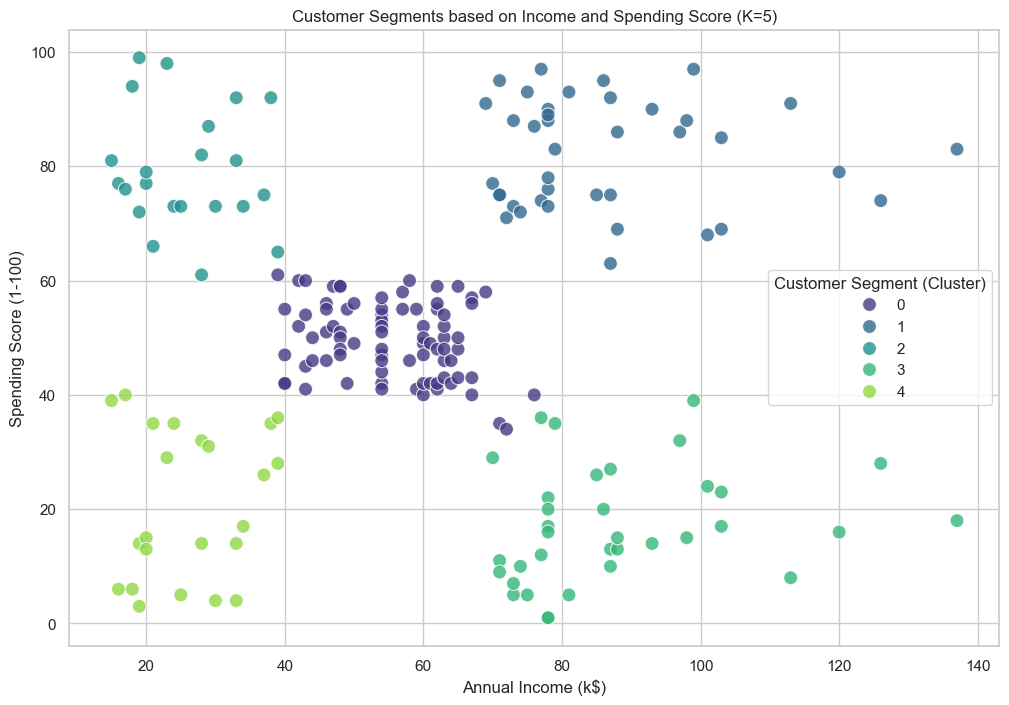


Interpreting the Segments (Typical interpretation for K=5):
Based on the plot, we can typically identify segments like:
  - Segment 1 (e.g., Bottom-Right): High Income, Low Spending Score (Careful/Thrifty High Earners)
  - Segment 2 (e.g., Top-Right):    High Income, High Spending Score (Target/Ideal Customers?)
  - Segment 3 (e.g., Middle):       Average Income, Average Spending Score (Standard Customers)
  - Segment 4 (e.g., Bottom-Left):  Low Income, Low Spending Score (Cautious Low Earners)
  - Segment 5 (e.g., Top-Left):     Low Income, High Spending Score (Careless/Enthusiast Low Earners?)

These segments provide valuable insights for targeted marketing campaigns.


In [25]:
if cluster_labels is not None:
    # Visualize the clusters using the ORIGINAL data for interpretability
    plt.figure(figsize=(12, 8))

    # Use seaborn's scatterplot which handles legends nicely
    sns.scatterplot(data=customer_df, x='Annual_Income_k', y='Spending_Score', hue='Cluster',
                    palette=sns.color_palette('viridis', n_colors=optimal_k), # Use a distinct color palette
                    s=100, # Marker size
                    alpha=0.8, # Marker transparency
                    legend='full') # Show legend

    plt.title(f'Customer Segments based on Income and Spending Score (K={optimal_k})')
    plt.xlabel('Annual Income (k$)')
    plt.ylabel('Spending Score (1-100)')
    plt.legend(title='Customer Segment (Cluster)')
    plt.grid(True)
    plt.show()

    # --- Interpretation of Clusters ---
    print("\nInterpreting the Segments (Typical interpretation for K=5):")
    # Note: The exact cluster number assignment might vary between runs if random_state wasn't fixed
    # or if different libraries/versions assign labels differently. Focus on the group characteristics.
    print("Based on the plot, we can typically identify segments like:")
    print("  - Segment 1 (e.g., Bottom-Right): High Income, Low Spending Score (Careful/Thrifty High Earners)")
    print("  - Segment 2 (e.g., Top-Right):    High Income, High Spending Score (Target/Ideal Customers?)")
    print("  - Segment 3 (e.g., Middle):       Average Income, Average Spending Score (Standard Customers)")
    print("  - Segment 4 (e.g., Bottom-Left):  Low Income, Low Spending Score (Cautious Low Earners)")
    print("  - Segment 5 (e.g., Top-Left):     Low Income, High Spending Score (Careless/Enthusiast Low Earners?)")
    print("\nThese segments provide valuable insights for targeted marketing campaigns.")

else:
    print("\nSkipping visualization as cluster labels are not available.")

*Interpretation:* The scatter plot visually separates the customers into distinct groups. By analyzing the position of each cluster on the axes, we can infer their characteristics. For example (the cluster numbers might vary, but the groups should be similar):
* **High Income, Low Spending:** Customers who earn a lot but spend cautiously at the mall.
* **High Income, High Spending:** Customers who earn a lot and spend freely (often a key target group).
* **Medium Income, Medium Spending:** The average customer group.
* **Low Income, Low Spending:** Customers who earn less and spend less.
* **Low Income, High Spending:** Customers who earn less but spend a lot (perhaps younger people, specific product enthusiasts?).

Understanding these segments allows businesses to design specific promotions, loyalty programs, or product recommendations tailored to each group's likely preferences and financial capacity.

---

### 7. Conclusion

This real-world example demonstrated how K-Means clustering can be used for customer segmentation based on annual income and spending score. By applying K-Means in an unsupervised manner, we identified distinct customer groups without prior labeling. The process involved:
1.  Loading and preparing real-world customer data.
2.  Selecting relevant features and scaling them.
3.  Using the Elbow Method to estimate the optimal number of clusters (K).
4.  Applying K-Means to group the customers.
5.  Visualizing and interpreting the resulting segments.

This analysis provides actionable insights for businesses, showcasing the practical value of unsupervised clustering techniques like K-Means.